In [1]:
from __future__ import print_function

In [2]:
import urllib
import bz2
import os
import numpy as np

In [3]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/ladybug/"
FILE_NAME = "problem-49-7776-pre.txt.bz2"
URL = BASE_URL + FILE_NAME

CAMERA_PARAMS = 6

In [4]:
if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

In [5]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [6]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

In [7]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]

n = CAMERA_PARAMS * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 49
n_points: 7776
Total number of parameters: 23622
Total number of residuals: 63686


In [8]:
import torch

def rotate_torch(points, rot_vecs):
    """Rotate points by given rotation vectors.

    Rodrigues' rotation formula is used.
    """
    theta = torch.norm(rot_vecs, dim=1, keepdim=True)
    v = torch.nan_to_num(rot_vecs / theta)
    dot = torch.sum(points * v, dim=1, keepdim=True)
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)

    return cos_theta * points + sin_theta * torch.cross(v, points, dim=1) + dot * (1 - cos_theta) * v

def project_torch(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    points_proj = rotate_torch(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj = -points_proj[:, :2] / points_proj[:, 2].unsqueeze(-1)  # add dimension for broadcasting
    
    f = camera_params[:, 6].unsqueeze(-1)
    k1 = camera_params[:, 7].unsqueeze(-1)
    k2 = camera_params[:, 8].unsqueeze(-1)
    n = torch.sum(points_proj**2, axis=1, keepdim=True)
    r = 1 + k1 * n + k2 * n**2
    points_proj *= r * f  # broadcasting will take care of the shape

    return points_proj

In [9]:
from numpy import linalg as LA

def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.

    Rodrigues' rotation formula is used.
    """
    # theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    # with np.errstate(invalid='ignore'):
    #     v = rot_vecs / theta
    #     v = np.nan_to_num(v)
    # dot = np.sum(points * v, axis=1)[:, np.newaxis]
    # cos_theta = np.cos(theta)
    # sin_theta = np.sin(theta)

    # return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v
    points = torch.from_numpy(points)
    rot_vecs = torch.from_numpy(rot_vecs)
    res = rotate_torch(points, rot_vecs)
    return res.numpy()

def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    # points_proj = rotate(points, camera_params[:, :3])
    # points_proj += camera_params[:, 3:6]
    # points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    # f = camera_params[:, 6]
    # k1 = camera_params[:, 7]
    # k2 = camera_params[:, 8]
    # n = np.sum(points_proj**2, axis=1)
    # r = 1 + k1 * n + k2 * n**2
    # points_proj *= (r * f)[:, np.newaxis]
    # return points_proj
    points = torch.from_numpy(points)
    camera_params = torch.from_numpy(camera_params)
    res = project_torch(points, camera_params)
    return res.numpy()

def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d, intr=None):
    """Compute residuals.

    `params` contains camera parameters and 3-D coordinates.
    """
    camera_params = params[:n_cameras * CAMERA_PARAMS].reshape((n_cameras, CAMERA_PARAMS))
    if intr is not None:
        camera_params = np.concatenate([camera_params, intr], axis=1)
    points_3d = params[n_cameras * CAMERA_PARAMS:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    #return LA.norm((points_proj - points_2d), axis=-1)
    return (points_proj - points_2d).ravel()

In [10]:
from scipy.sparse import lil_matrix

def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * CAMERA_PARAMS + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(CAMERA_PARAMS):
        A[2 * i, camera_indices * CAMERA_PARAMS + s] = 1
        A[2 * i + 1, camera_indices * CAMERA_PARAMS + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * CAMERA_PARAMS + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * CAMERA_PARAMS + point_indices * 3 + s] = 1

    return A

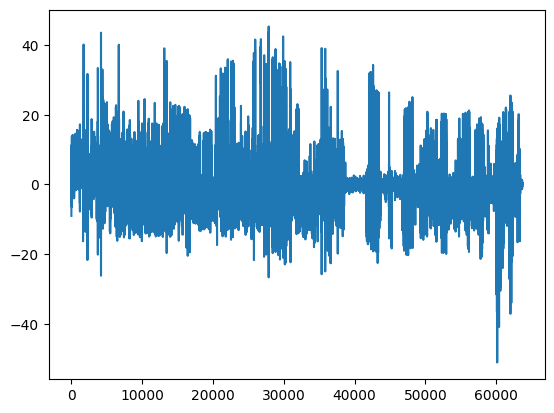

In [11]:
import matplotlib.pyplot as plt

if CAMERA_PARAMS == 6:
    x0 = np.hstack((camera_params[..., :CAMERA_PARAMS].ravel(), points_3d.ravel()))
    rest_of_params = camera_params[..., CAMERA_PARAMS:]
else:
    x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
    rest_of_params = None
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d, intr=rest_of_params)

plt.plot(f0)

In [12]:
f0.shape

(63686,)

In [13]:
np.sum((f0**2))/2

850912.4606808405

In [14]:
import time
from scipy.optimize import least_squares

A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',args=(n_cameras, n_points, camera_indices, point_indices, points_2d), kwargs={'intr':rest_of_params})
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5091e+05                                    4.52e+06    
       1              2         7.7687e+04      7.73e+05       7.58e+02       6.99e+05    
       2              3         2.4685e+04      5.30e+04       1.85e+03       1.25e+05    
       3              4         1.7320e+04      7.36e+03       1.77e+02       2.07e+04    
       4              5         1.6729e+04      5.91e+02       2.87e+02       1.08e+04    
       5              6         1.6556e+04      1.73e+02       8.28e+00       2.47e+02    
       6              7         1.6556e+04      1.64e-01       5.31e+00       1.10e+03    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 8.5091e+05, final cost 1.6556e+04, first-order optimality 1.10e+03.


In [15]:
f1 = fun(res.x, n_cameras, n_points, camera_indices, point_indices, points_2d)
np.sum((f1**2))/2

IndexError: index 6 is out of bounds for dimension 1 with size 6

In [ ]:
def reprojerr(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.

    `params` contains camera parameters and 3-D coordinates.
    """
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return LA.norm((points_proj - points_2d), axis=-1).sum()

In [ ]:
initial = reprojerr(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)
initial

134013.25637740275

In [ ]:
final = reprojerr(res.x, n_cameras, n_points, camera_indices, point_indices, points_2d)
final

18510.198321420467